# Volumeter

TODO
- measurementCycle(loweringSpeed)
- calibrateHolder()
- syncMeasurementData() # Needs to incorporate some sort of interpolation to sync based on immersion depth insted of samples. Maybe the volume should be calculated in this function.
- ~calculateVolume()
- visualize(), matplotlib, plotly, something else?
- exportCSV()
- Mittaustelineen valinta-UI widgetseillä
- Nippusiteiden paikkojen valinta widgetseillä

Pandas resampling
https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
https://stackoverflow.com/questions/20941973/python-pandas-interpolate-with-new-x-axis


# TODO 2
- refactoroi yllä oleviin funktioihin
- Holderin nimeäminen tallentamisen yhteydessä, ehkä joku visualisaatio datasta ennen tallennusta
- Holderin valintakäyttöliittymä. Valittu holder tallentuu muuttujaan, joka pysyy session ajan. Jos mitattauksen alussa tuo muuttuja on tyhjä, niin kutsutaan valintakäyttöliittymää
- CSV export Exceliin, ehkä myös xlsx exporttaus jos siihen löytyy helppo kirjasto
- Mittausdata tallennetaan omaan hakemistoonsa
- Kysy käyttäjältä ennen tallenusta näyttääkö mittaus/synkkays hyvälle. Kysytään tämä heti kun häkki on nostettu veden pinnalle
- Datankäsittelyn voi tehdä sillä välin kun häkkiä nostetaan ylös
- Jos data ei ole ok, niin kysy mitataanko uudestaan vai haluatko tallentaa häkki- ja mittausdata raakana.
- Load cell calibration on häkkiriippuvainen eli kun häkki vaihtuu niin pitää ladata uudet arvot.
- Load cell calibration pitänee tehdä häkin kalibroinnin yhteydessä. Ehkä load cell calibration pitäisi tallentaa häkkidatam kanssa samaan tiedostoon? Tai sitten niillä on samat tiedostonimet?


In [ ]:
from IPython.display import Image

In [ ]:
import serial
import pandas as pd
import numpy as np
import time
import os
from math import ceil
from matplotlib import pyplot as plt
from IPython.core.display import clear_output
from datetime import datetime
import DataProcessing as dp
import Hardware as hw

In [9]:
def measure():
    try:
        hw.measurementCycle()
    except:
        pass
    display(Image('demo.jpeg'))

In [ ]:
global loadCellConstants
global mcSerial
global sensorSerial
global homingDone

# HW
def readLoadCellCalibration():
    '''Loads the load cell calibration values from a CSV file called loadCellCalibration.csv.'''
    cal = np.genfromtxt('loadCellCalibration.csv', delimiter=',')
    return cal

# HW
def loadCellToGrams(value):
    '''Converts a load cell reading to grams based on the calibration values.'''
    return value*loadCellConstants[0] + loadCellConstants[1]

#HW
def initMotionControl(motionControlPort='/dev/ttyUSB1'):
    '''Initializes the motion control serial port.
    
    Uses a default of /dev/ttyUSB1 but the port can be given as an argument.
    '''
    global mcSerial
    global homingDone
    mcSerial = serial.Serial(port=motionControlPort, baudrate=115200)
    homingDone = False
# HW
def initSensors(sensorPort='/dev/ttyUSB0'):
    '''Initializes the sensor serial port.
    
    Uses a default of /dev/ttyUSB0 but the port can be given as an argument.
    '''
    global sensorSerial
    global loadCellConstants
    loadCellConstants = readLoadCellCalibration()
    
    sensorSerial = serial.Serial(port=sensorPort, baudrate=115200)
# HW
def closeSerial(serial):
    '''Closes the serial port that was given as an argument'''
    serial.close()
# HW
def sendMotionCommand(cmd):
    '''Sends the given gcode command to the motion control serial port.'''
    mcSerial.write('{0}\n'.format(cmd).encode('utf-8'))
    mcSerial.flushInput()
    grbl_out = mcSerial.readline()
    return grbl_out.decode()

# HW
def motionFinished(wait=False):
    '''Returns True if the motion control system is idle
    
    Giving wait=True as an argument waits until the motion control system becomes idle and returns True.
    '''
    finished = False
    if(wait):
        while(not finished):
            time.sleep(0.5)
            grbl_out = sendMotionCommand('?')
            finished = 'Idle' in str(grbl_out)
        return True
    else:
        grbl_out = sendMotionCommand(serial, '?')
        return 'Idle' in str(grbl_out)

# HW
def homingCycle():
    '''Homes the motion control system axes.'''
    
    global homingDone
    
    cycle = ['?', 'G91', 'G38.2Z2500F2000', 'G1Z-20F1000',
             'G38.2X-560Z-560F600', 'G1X10Z10F600', 'G10L20P1X0Y0Z0',
            'G90', 'G1Z-1650F3000']
    for c in cycle:
        sendMotionCommand(c)
    motionFinished(wait=True)
    homingDone = True

# HW
def startup():
    '''Initializes motion control and sensors, runs the homing cycle.'''
    initMotionControl()
    initSensor()
    homingCycle()

# HW
def recordSensors(numSamples):
    '''Records the sensors for the given number of samples and return the in a pandas DataFrame.'''
    
    # TODO make the smoothing better, maybe use the smooth function from Data_sync_test
    
    sensorSerial.reset_input_buffer()
    samplesRead = 0
    df = pd.DataFrame(columns=['time', 'loadCell', 'level'], dtype='float')
    while(samplesRead < numSamples):
        try:
            data = np.array(sensorSerial.readline().decode().rstrip().split(','))
            data = data.astype(np.float)
            df.loc[len(df)] = data
            samplesRead += 1
        except:
            pass
    # Will fixing this inplace=False issue break anything?
    # df = df.set_index(['time'])
    return df

# DP, Might already be there
def resampleDF(df, resolution=0.5):
    '''Resamples the data to 0.5 resolution by default on the index axis.'''
    idx = pd.Index(np.arange(0, ceil(df.index.values.max()), resolution))
    newIdx = idx.union(df.index)
    dfR = df.reindex(newIdx).interpolate(method='index')
    dfR = dfR.reindex(idx)
    return dfR

# HW
def meanLoadCell(numSamples):
    '''Returns the mean load cell value of given number of samples'''
    data = recordSensors(numSamples)
    return data['loadCell'].mean()

# HW
def meanWeight(numSamples):
    '''Returns the mean weight in grams of given number of samples'''
    data = recordSensors(numSamples)
    mean = data['loadCell'].mean()
    return loadCellToGrams(mean)

# Calibration
def calibrateLoadCell(numWeights=1):
    # TODO Interpolate depth data to 0,5mm resolution for example
    '''Runs a load cell calibration wizard.
    
    numWeights argument can be used to tell how many calibration weights you want to use.
    The calibration values are saved to loadCellCalibration.csv if the user accepts the new calibration values.
    '''
    sendMotionCommand('G1Z-1620F1000')
    motionFinished(True)
    
    grams = []
    values = []
    print("Load Cell Calibration")
    print("Leave the specimen holder empty")
    input("Hit enter when the specimen holder is stationary")
    print("Wait for 5 seconds...")
    grams.append(0.0)
    values.append(meanLoadCell(80*5))
    while(numWeights > 0):
        numWeights -= 1
        while(True):
            try:
                calWeight = input("Mass of the calibration weight in kg: ").rstrip().replace(',', '.')
                grams.append(float(calWeight)*1000.0)
                break
            except:
                print("Insuitable mass value")

        print("Add the calibratrion weight to the specimen holder")
        input("Hit enter when the specimen holder is stationary")
        print("Wait for 5 seconds...")
        values.append(meanLoadCell(80*5))
    calibrationConstants = np.polyfit(values, grams, 1)
    print("Calibration: y = {:.2f}x+{:.2f}".format(calibrationConstants[0], calibrationConstants[1]))
    save = input("Save calibration (y/n)")
    if('y' in save.lower()):
        np.savetxt('loadCellCalibration.csv', calibrationConstants, delimiter=',')
        print('Calibration saved')
    else:
        print('Calibration cancelled')
        
# Calibration
def calibrateHolder(numTimes=3):
    '''Runs a specimen holder calibration cycle and asks the user for a name of the calibration.

    Calibration values are saved to holderCalibrations.csv file whose column specifies the name of the holder.
    '''
    
    loweringSpeed = 2000 # mm/min
    topHeigth = 400
    bottomHeigth = -850
    smoothing = 10
    
    if(not homingDone):
        print("Motion control system is not homed. Please run the homingCycle() first.")
        return None

    motionFinished(wait=True)

    # Move on top of the water tank
    movementsToTopOfTank = ['?', 'G90', 'G1X0Z-1640F6000','G1X0Z-50F4000', 'G1X540Z540F3000','G1X540Z{}F2000'.format(topHeigth)]
    for c in movementsToTopOfTank:
        sendMotionCommand(c)
    motionFinished(wait=True)
    
    # Dip the holder to the water to make it wet
    sendMotionCommand('G1X540Z{}F2000'.format(bottomHeigth))
    sendMotionCommand('G1X540Z{0}F2000'.format(topHeigth))
    motionFinished(wait=True)
    
    cal = pd.DataFrame(columns=['depth', 'force'], dtype='float')
    
    firstMeasurement = True
    while(numTimes > 0):
        numTimes -= 1
        # Wait for the movement to stabilize
        time.sleep(5)
        sendMotionCommand('G1X540Z{}F2000'.format(bottomHeigth))
        time.sleep((loweringSpeed/60)/20) # 20mm/s^2 acceleration, start recording data after the acceleration
        data = recordSensors(86*((topHeigth-bottomHeigth)/(loweringSpeed/60) + 2))
        motionFinished(wait=True)
        time.sleep(1)
        sendMotionCommand('G1X540Z{0}F2000'.format(topHeigth))
        
        df = pd.DataFrame(columns=['depth', 'force'], dtype='float')
        # TODO This should be its own function?
        df['depth'] = ((data['time']-data['time'].iloc[int(smoothing/2)])*loweringSpeed/60)/1000.0 + data['level'] - data['level'].iloc[int(smoothing/2)]
        df['force'] = data['loadCell'].apply(loadCellToGrams)
        # To make displacement positive, multiply force by -1.0
        df['force'] *= -1.0
        df['force'] = df['force'].rolling(10, center=True).median()
        df = df.dropna()
        df = df.set_index(['depth'])
        df = resampleDF(df)
        print(df.head(30))
        print('---')
        #df.to_pickle('{}_specimen_holder'.format(datetime.now()))
        
        if(firstMeasurement):
            cal = df.copy()
        else:
            cal = pd.DataFrame(pd.concat((cal, df), axis=1).mean(axis=1), columns=['holder1'])
        
        motionFinished(wait=True)
        firstMeasurement = False
    
    for c in reversed(movementsToTopOfTank):
        sendMotionCommand(c)
    motionFinished(wait=True)  
    
    # TODO add to data base instead? Should the load cell calibration be done at the same time? Maybe just the empty weight needs to be recorded
    cal.to_pickle('{}_specimenHolderTestData'.format(datetime.now()))
    #cal.to_csv('{}_specimenHolderTestData.csv'.format(datetime.now()))
        
# UI
def selectSpecimenHolder():
    '''Lists the names of the available specimen holder calibrations and asks the user to select one of them.'''

# HW
def measurementCycle():
    '''Runs the measurement cycle.'''
    # TODO make a function that is called from calibrateHolder() and measurementCycle(). Put this in the HW module
    
    loweringSpeed = 2000 # mm/min
    topHeigth = 400
    bottomHeigth = -850
    smoothing = 10
    
    if(not homingDone):
        print("Motion control system is not homed. Please run the homingCycle() first.")
        return None
    
    #Record the mean weight of the specimen
    mw = meanWeight(200)
    print('Specimen weight: {:.2f}'.format(mw))
    
    movementsToTopOfTank = ['?', 'G90', 'G1X0Z-1640F6000','G1X0Z-50F4000', 'G1X540Z540F3000','G1X540Z{}F2000'.format(topHeigth)]
    for c in movementsToTopOfTank:
        sendMotionCommand(c)
    motionFinished(wait=True)
    
    # Wait for the movement to stabilize
    time.sleep(5)
    sendMotionCommand('G1X540Z{}F2000'.format(bottomHeigth))
    time.sleep((loweringSpeed/60)/20) # 20mm/s^2 acceleration, start recording data after the acceleration
    data = recordSensors(86*((topHeigth-bottomHeigth)/(loweringSpeed/60) + 2))
    motionFinished(wait=True)
    time.sleep(1)
    sendMotionCommand('G1X540Z{0}F2000'.format(topHeigth))
    
    try:
        df = pd.DataFrame(columns=['depth', 'force'], dtype='float')
        df['depth'] = ((data['time']-data['time'].iloc[int(smoothing/2)])*loweringSpeed/60)/1000.0 + data['level'] - data['level'].iloc[int(smoothing/2)]
        df['force'] = data['loadCell'].apply(loadCellToGrams)
        # To make displacement positive, multiply force by -1.0
        df['force'] *= -1.0
        df['force'] = df['force'].rolling(10, center=True).median()
        df = df.dropna()
        df = df.set_index(['depth'])
        df = resampleDF(df)
        #df['force'] -= mw
        print(df.head(30))
    except:
        print('Data processing failed')
    
    for c in reversed(movementsToTopOfTank):
        sendMotionCommand(c)
    motionFinished(wait=True)  
    
    df.to_pickle('{}_testMeasurement-{}'.format(datetime.now(), mw))
    
    holderData = pd.read_pickle('specimenHolder')
    diff = dp.synchronizeMeasurement(df, holderData)
    diff.index.name = 'Depth'
    #diff.dropna(axis='columns')
    diff.to_csv('{}_testMeasurementDiff-{}.csv'.format(datetime.now(), mw), sep = ';', decimal=",")
    #diff = df.iloc[:,0]-holderData.iloc[:,0]
    smoothDiff = dp.smooth(diff, 55)
    fig=plt.figure()
    plt.plot(diff)
    #plt.plot(smoothDiff)
    #plt.plot(holderData)
    #plt.plot(df)
    plt.show()
        

In [ ]:
hw.initMotionControl()
finished = hw.motionFinished(wait=True)
hw.homingCycle()
#closeSerial(mcSerial)

In [ ]:
hw.closeSerial(hw.mcSerial)

In [ ]:
calibrateHolder(3)

In [ ]:
hw.initSensors('/dev/ttyUSB2')

In [ ]:
hw.closeSerial(mcSerial)
hw.closeSerial(sensorSerial)

Specimen weight: 8611.12


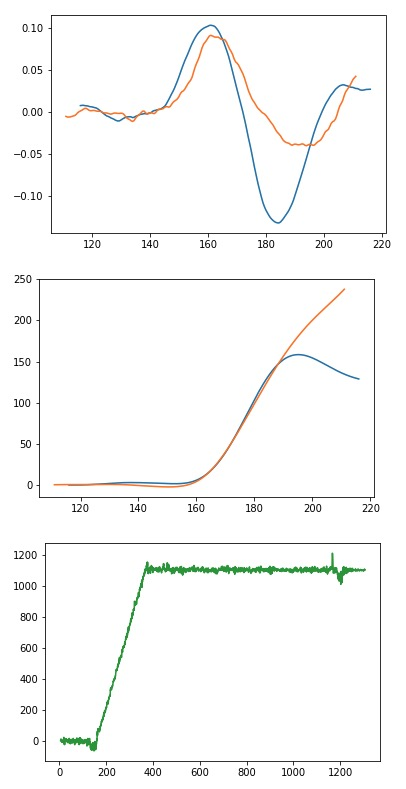

In [12]:
measure()

In [ ]:
os.system('sudo ./shutdown.sh')